In [1]:
# plot correlations between tracers 

In [178]:
from neuromaps.images import load_data, load_gifti, annot_to_gifti, relabel_gifti
from neuromaps.parcellate import Parcellater
from neuromaps.datasets import fetch_annotation
from neuromaps import transforms 

from scipy.spatial.distance import squareform
import networkx as nx

import numpy as np
import pandas as pd
from os import getcwd
from os.path import dirname 
import seaborn as sns 
import matplotlib.pyplot as plt


In [179]:
# define path
path = dirname(getcwd()) + '/'

# load in different parcellation files
dk_fsaverage_10k = (path + 'parcellations/atlas-desikankilliany_space-fsaverage_den-10k_hemi-L.label.gii.gz',
                     path + 'parcellations/atlas-desikankilliany_space-fsaverage_den-10k_hemi-R.label.gii.gz')
dk_fsaverage_164k = (path + 'parcellations/atlas-desikankilliany_space-fsaverage_den-164k_hemi-L.aparc-1.annot',
                     path + 'parcellations/atlas-desikankilliany_space-fsaverage_den-164k_hemi-R.aparc-1.annot')
dk_mni = path + 'parcellations/atlas-desikankilliany_space-MNI_res-1mm.nii.gz'

# make sure label IDs are consecutive across hemispheres
dk_fsaverage_10k = relabel_gifti(dk_fsaverage_10k)
dk_fsaverage_164k = annot_to_gifti(dk_fsaverage_164k)  # this does relabel_gift and also converts the annot file to gifti

# make the parcellaters for each space
parcellater_fs10k = Parcellater(dk_fsaverage_10k, 'fsaverage')
parcellater_fs164k = Parcellater(dk_fsaverage_164k, 'fsaverage')
parcellater_mni = Parcellater(dk_mni, 'MNI152')

# download the regions for MNI152, take indecies of surface rois  
rois = pd.read_csv(path+'parcellations/atlas-desikankilliany.csv')
rois = rois[(rois['structure'] == 'cortex')].index.to_numpy()

In [180]:
path = dirname(getcwd()) + '/'

data = pd.read_csv(path + '/tables/correlations_in_replication_sample.csv')
sources = data[data['fdr_corrected_p_value'] < 0.05]['source']
paper = [s.split('_')[0] for s in sources]
desc = [s.split('_')[1] for s in sources]
space = ['fsaverage', 'fsaverage', 'fsaverage', 'MNI152','MNI152','MNI152','fsLR' ,'fsLR' ,'fsLR' ,'fsLR' ,'fsLR' ,'MNI152', 'fsLR']

In [181]:
annotations = []
for p, d,s  in zip(paper, desc, space) :
    list(fetch_annotation(source=p, desc=d, space=s, return_single=False).keys())
    annotations.extend(  list(fetch_annotation(source=p, desc=d, space=s, return_single=False).keys()))

In [182]:
parcellated = dict([])

# go over each annotation and parcellate depending on the space 
for (src, desc, space, den) in annotations:

    annot = fetch_annotation(source=src, desc=desc, space=space, den=den)
    if space == 'MNI152':
        parcellater = parcellater_mni
    elif space == 'fsaverage' and den == '164k':
        parcellater = parcellater_fs164k
    elif space == 'fsLR' and den == '164k':
        space = 'fsaverage'
        annot = transforms.fslr_to_fsaverage(annot, target_density='164k')
        parcellater = parcellater_fs164k
    elif space == 'fsLR' and den != '164k':
        # unfortunately for fsLR-4k we are upsampling to fsaverage-10k to parcellate but it should be fine
        space = 'fsaverage'
        annot = transforms.fslr_to_fsaverage(annot, target_density='10k')
        parcellater = parcellater_fs10k

    parcellated[desc] = parcellater.fit_transform(annot, space=space, ignore_background_data=True)

    # if subcortex included remove 
    if parcellated[desc].shape == (1,83):
        parcellated[desc] = parcellated[desc][0][rois]

parcellated = pd.DataFrame(parcellated)


/Users/laurituominen/anaconda3/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:803: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)


In [183]:
parcellated

,dasb,cimbi36,sb207145,flubatine,fmpepd2,carfentanil,fcgradient01,megtheta,meggamma1,megalpha,myelinmap,ucbj,cbv
0,4.858744,58.675255,2.577081,9.819168,10.305819,21.671598,1.047140,0.245840,0.016993,0.340052,1.336933,3.389757,4669.047852
1,6.983108,44.467213,2.040007,10.394981,8.015144,34.103012,-1.786409,0.294815,0.023948,0.224471,1.147527,3.522977,5038.153320
2,3.687662,55.912239,2.035033,10.994048,9.360754,24.997370,4.129920,0.303023,0.024472,0.211136,1.300453,3.146814,4061.233887
3,6.035793,52.887188,1.761045,9.438647,7.788053,6.001631,-4.388083,0.208343,0.015949,0.423510,1.518472,3.903508,7563.857910
4,9.050703,30.015448,2.234023,7.266660,5.924977,26.303360,1.056533,0.239515,0.022868,0.286232,1.180475,2.418970,4660.116699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,4.214192,53.908180,2.408686,9.402723,10.123050,24.093927,-2.024122,0.242956,0.019370,0.328782,1.301806,3.668499,4594.315918
64,4.030276,58.710613,2.205722,9.708656,8.181634,23.757314,6.307582,0.274031,0.036485,0.179546,1.206276,4.002494,2899.072754
65,8.621255,38.956345,2.119156,7.669613,6.172987,26.466046,4.587040,0.242324,0.026268,0.247709,1.077419,3.026434,5630.090332
66,7.395446,53.104507,1.902578,10.682926,8.406543,12.300595,-3.766580,0.240034,0.017274,0.327352,1.683642,3.653361,5357.941406


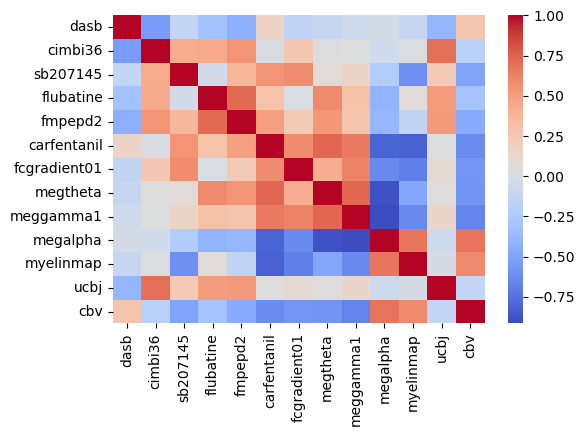

In [194]:
# plot correlation map
corrs = parcellated.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corrs, cmap='coolwarm')
plt.savefig(path + '/figures/annotation_correlation_matrix.jpg')

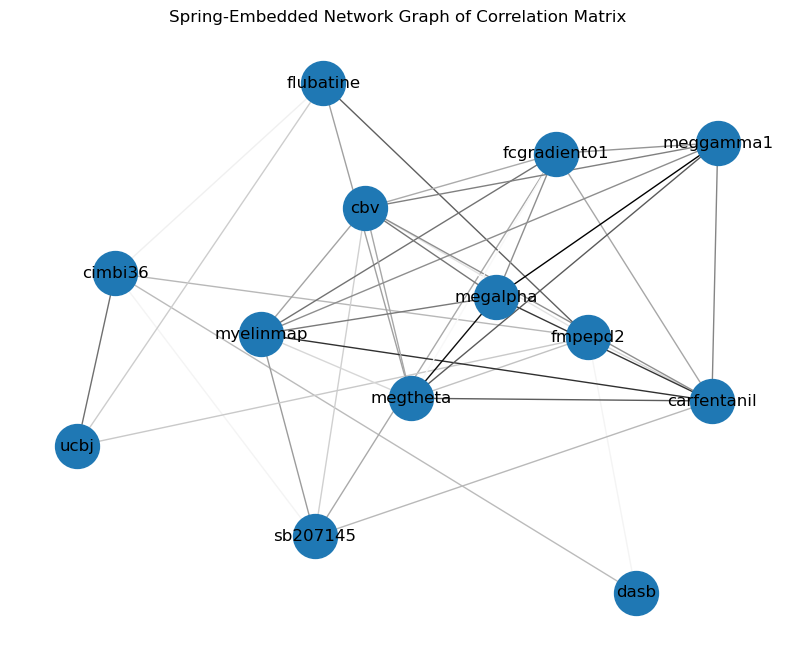

In [206]:
# explore structure 
corrs[abs(corrs) < 0.4] = 0
corrs[corrs==1.0] = 0
corrs= abs(corrs)

network = nx.from_numpy_array(corrs.to_numpy())

pos = nx.spring_layout(network, seed=2233, k=2, weight=10)

colors = list(nx.get_edge_attributes(network, 'weight').values())
labels = {i: label for i, label in enumerate(corrs.columns)}
fig, ax = plt.subplots(figsize=(10, 8))

nx.draw_networkx(network, pos, labels=labels, node_size=1000,
                     edge_color=colors, edge_cmap=plt.cm.gray_r)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Spring-Embedded Network Graph of Correlation Matrix")
plt.savefig(path + '/figures/spring_network_correlation_matrix.jpg')
plt.show()

